# Bayesian black-box model-predictive control

An Expected Free Energy minimizing agent based on a nonlinear autoregressive model with exogenous input.

## System: driven damped pendulum

Consider a single pendulum with angle $\theta(t)$ and input $u(t)$ evolving according to:

$$ \ddot{\theta} + \frac{\mathcal{g}}{l} \sin(\theta) + \frac{\gamma}{l} \dot{\theta} = \frac{1}{ml} u\, .$$

where $m$ is mass, $l$ is length, $\gamma$ is damping and $\mathcal{g}$ is Earth's gravity.

In [2]:
using Revise
using ForwardDiff
using Optim
using RxInfer
using SpecialFunctions
using LinearAlgebra
using ProgressMeter
using Distributions
using Plots; default(grid=false, label="", linewidth=3,margin=20Plots.pt)

includet("../NARXAgents.jl"); using .NARXAgents
includet("./Pendulums.jl"); using .Pendulums

In [56]:
# System parameters
sys_mass = 1.0
sys_length = 2.0
sys_damping = 0.1
sys_tqlims = (-3., 3.)
sys_mnoise_sd = 1e-2
Δt = 0.2
normalize_output = 1.0

1.0

In [57]:
init_state = [0.0, 0.0]
pendulum = SPendulum(init_state = init_state, 
                     torque_lims = sys_tqlims,
                     mass = sys_mass, 
                     length = sys_length, 
                     damping = sys_damping, 
                     mnoise_sd = sys_mnoise_sd, 
                     Δt=Δt,
                     norm_output=normalize_output)

SPendulum([0.0, 0.0], -0.007629475501782037, 0.0, (-3.0, 3.0), 0.2, 1.0, 2.0, 0.1, 0.01, 1.0)

### Test system

In [58]:
N = 600
tsteps = range(0.0, step=Δt, length=N)

0.0:0.2:119.8

In [59]:
# Inputs
A  = rand(10)*200 .- 100
Ω  = rand(10)*3
controls = mean([A[i]*sin.(Ω[i].*tsteps) for i = 1:10])./2;

In [60]:
states = zeros(2,N)
observations = zeros(N)
torques = zeros(N)

for k in 1:N
    states[:,k] = pendulum.state
    observations[k] = pendulum.sensor
    step!(pendulum, controls[k])
    torques[k] = pendulum.torque
end

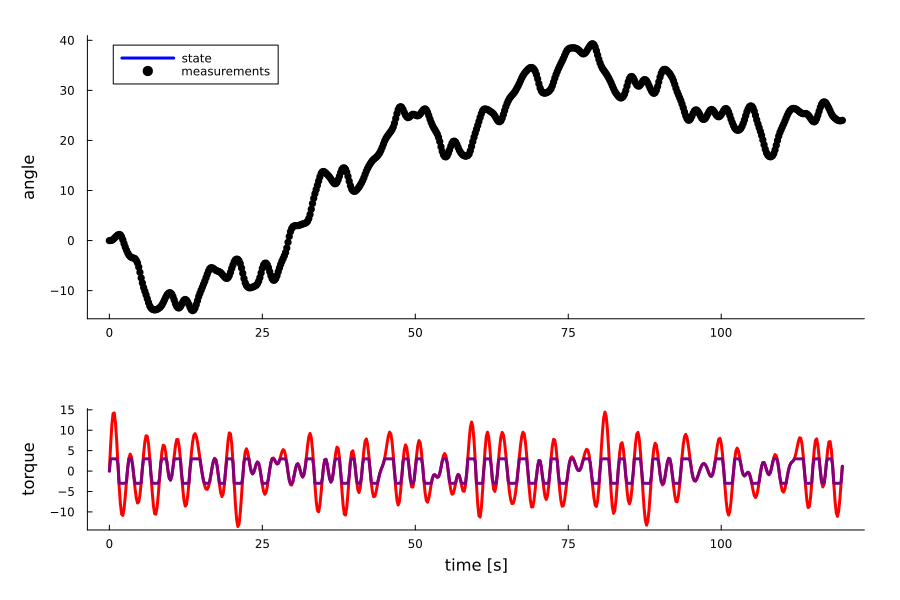

In [61]:
p1 = plot(ylabel="angle")
plot!(tsteps, states[1,:], color="blue", label="state")
scatter!(tsteps, observations, color="black", label="measurements")
p2 = plot(xlabel="time [s]", ylabel="torque")
plot!(tsteps, controls[:], color="red")
plot!(tsteps, torques[:], color="purple")
plot(p1,p2, layout=grid(2,1, heights=[0.7, 0.3]), size=(900,600))

## Parameter estimation

In [62]:
# NARX settings
Ly = 3
Lu = 3
D = 1 + Ly + Lu

M = 50
centers = 100randn(D,M-1)
scales  = 1e-3ones(M-1)

# Specify prior distributions
pτ0 = GammaShapeRate(1e3, 1e0)
pθ0 = MvNormalMeanCovariance(randn(M)./100, 10diagm(ones(M)))
goal = NormalMeanVariance(3.14./normalize_output, 1e-3)

T = 15
u_prior = 0.0
num_iters = 4

agent = NARXAgent(pθ0, pτ0, 
                  goal_prior=goal, 
                  delay_in=Lu, 
                  delay_out=Ly, 
                  basisfn_class="rbf",
                  basisfn_params=(centers,scales),
                  thorizon=T,
                  control_prior=u_prior,
                  num_iters=num_iters)

NARXAgent(FactorGraphModel(), Constraints:
  marginals form:
  messages form:
  factorisation:
    q(θ, τ) = q(θ)q(τ)
Options:
  warn = true
, [Inf], MvNormalMeanCovariance(
μ: [0.009351571127575854, -0.012983071747986599, -0.004414876278016599, -0.0007213635445429044, 0.005343694221189286, 0.006565550839639051, 0.0041740451789622655, 0.00605983186294343, 0.015704524180292202, -0.0164000692199386  …  0.012671496789089404, -0.00020452951641458883, -0.0014075124423712818, 0.008640595237551098, 0.02126704498111887, 0.010837706344415388, -0.003990321751888427, -0.00137026169885548, 0.012025484850686325, 0.0011933000308986164]
Σ: [10.0 0.0 … 0.0 0.0; 0.0 10.0 … 0.0 0.0; … ; 0.0 0.0 … 10.0 0.0; 0.0 0.0 … 0.0 10.0]
)
, GammaShapeRate{Float64}(a=1000.0, b=1.0), NormalMeanVariance{Float64}(μ=3.14, v=0.001), 15, 4, 0.0, "rbf", ([-58.76704700515598 159.14350763512923 … 22.33678087952101 150.10562199281011; 34.05787731325838 -101.45936667581128 … -103.39963559287027 -5.916074872613436; … ; 115.771

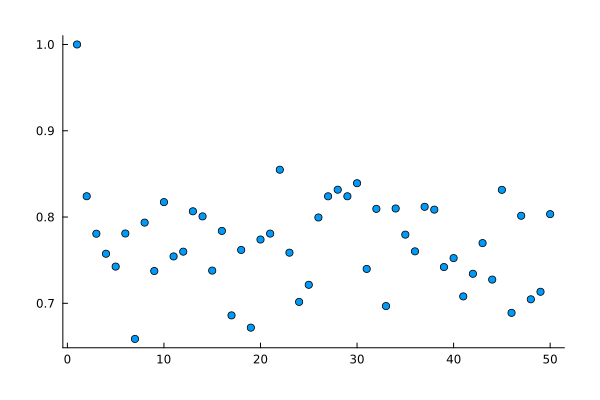

In [63]:
scatter(agent.basisfn(randn(D)))

In [64]:
py = []
qθ = [pθ0]
qτ = [pτ0]
FE = zeros(num_iters,N)

@showprogress for k in 1:(N-T)
    
    # Make predictions
    push!(py, predictions(agent, controls[k:k+T], time_horizon=T))
    
    # Update beliefs
    NARXAgents.update!(agent, observations[k], controls[k])
    push!(qθ, agent.qθ)
    push!(qτ, agent.qτ)
    
    # Evaluate
    FE[:,k] = agent.free_energy
end

Progress:   2%|▉                                        |  ETA: 0:00:05

Progress:   4%|█▋                                       |  ETA: 0:00:06

Progress:   6%|██▍                                      |  ETA: 0:00:05

Progress:   8%|███▏                                     |  ETA: 0:00:05

Progress:   9%|███▉                                     |  ETA: 0:00:06

Progress:  11%|████▌                                    |  ETA: 0:00:06

Progress:  12%|█████▏                                   |  ETA: 0:00:06

Progress:  14%|█████▉                                   |  ETA: 0:00:06

Progress:  16%|██████▌                                  |  ETA: 0:00:05

Progress:  17%|███████▏                                 |  ETA: 0:00:06

Progress:  19%|███████▋                                 |  ETA: 0:00:06

Progress:  20%|████████▎                                |  ETA: 0:00:06

Progress:  22%|████████▉                                |  ETA: 0:00:06

Progress:  23%|█████████▌                               |  ETA: 0:00:05

Progress:  25%|██████████▏                              |  ETA: 0:00:05

Progress:  26%|██████████▊                              |  ETA: 0:00:05

Progress:  28%|███████████▌                             |  ETA: 0:00:05

Progress:  30%|████████████▏                            |  ETA: 0:00:05

Progress:  32%|█████████████▏                           |  ETA: 0:00:05

Progress:  35%|██████████████▎                          |  ETA: 0:00:04

Progress:  38%|███████████████▍                         |  ETA: 0:00:04

Progress:  40%|████████████████▌                        |  ETA: 0:00:04

Progress:  43%|█████████████████▋                       |  ETA: 0:00:03

Progress:  46%|██████████████████▉                      |  ETA: 0:00:03

Progress:  49%|████████████████████                     |  ETA: 0:00:03

Progress:  52%|█████████████████████▍                   |  ETA: 0:00:03

Progress:  55%|██████████████████████▋                  |  ETA: 0:00:02

Progress:  58%|███████████████████████▊                 |  ETA: 0:00:02

Progress:  61%|█████████████████████████                |  ETA: 0:00:02

Progress:  64%|██████████████████████████▏              |  ETA: 0:00:02

Progress:  66%|███████████████████████████▎             |  ETA: 0:00:02

Progress:  68%|███████████████████████████▉             |  ETA: 0:00:02

Progress:  70%|████████████████████████████▊            |  ETA: 0:00:02

Progress:  73%|█████████████████████████████▉           |  ETA: 0:00:02

Progress:  76%|███████████████████████████████▏         |  ETA: 0:00:01

Progress:  79%|████████████████████████████████▍        |  ETA: 0:00:01

Progress:  82%|█████████████████████████████████▌       |  ETA: 0:00:01

Progress:  84%|██████████████████████████████████▌      |  ETA: 0:00:01

Progress:  87%|███████████████████████████████████▌     |  ETA: 0:00:01

Progress:  89%|████████████████████████████████████▋    |  ETA: 0:00:01

Progress:  92%|█████████████████████████████████████▋   |  ETA: 0:00:00

Progress:  94%|██████████████████████████████████████▋  |  ETA: 0:00:00

Progress:  97%|███████████████████████████████████████▊ |  ETA: 0:00:00

Progress: 100%|█████████████████████████████████████████| Time: 0:00:05


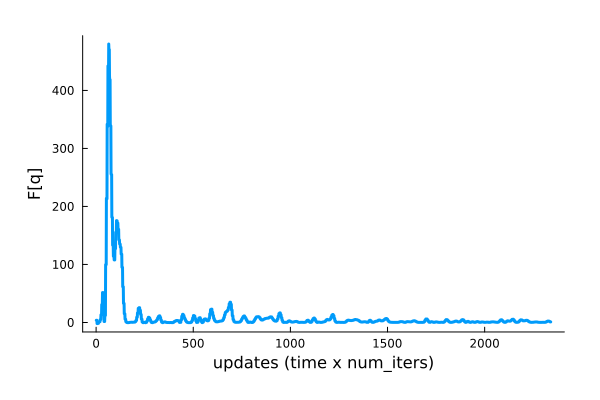

In [65]:
plot(reshape(FE[:,1:(N-T)], (num_iters*(N-T),)), xlabel="updates (time x num_iters)", ylabel="F[q]")

In [66]:
vθ = cat( var.(qθ)...,dims=2)
mθ = cat(mean.(qθ)...,dims=2)

50×586 Matrix{Float64}:
  0.00935157    0.0098636    …    0.881651    0.887884    0.893856
 -0.0129831    -0.0125613       -35.1106    -35.1222    -35.1334
 -0.00441488   -0.00401608       11.4746     11.4737     11.4714
 -0.000721364  -0.000333315      61.1697     61.1684     61.1668
  0.00534369    0.00572443       27.8701     27.8679     27.8672
  0.00656555    0.00696599   …  -18.5019    -18.5019    -18.5012
  0.00417405    0.00451168       -7.98832    -7.99211    -7.99368
  0.00605983    0.00646637      -71.1163    -71.1249    -71.1294
  0.0157045     0.0160819       -16.6533    -16.6636    -16.6695
 -0.0164001    -0.0159821        30.8096     30.8116     30.8101
  ⋮                          ⋱                            ⋮
 -0.00020453    0.000171942     -67.6423    -67.6457    -67.6445
 -0.00140751   -0.00101373       12.9144     12.9114     12.907
  0.0086406     0.009013         40.4349     40.4254     40.4183
  0.021267      0.021693        -21.4616    -21.4547    -21.4511
  0.

In [67]:
# pw = []
# for m in 1:M
#     pwm = plot()
#     plot!(mθ[m,:], ribbon=sqrt.(vθ[m,:]), color="purple", ylabel="θ_$m")
#     push!(pw,pwm)
# end
# plot(pw..., layout=(M,1), size=(600,M*200))

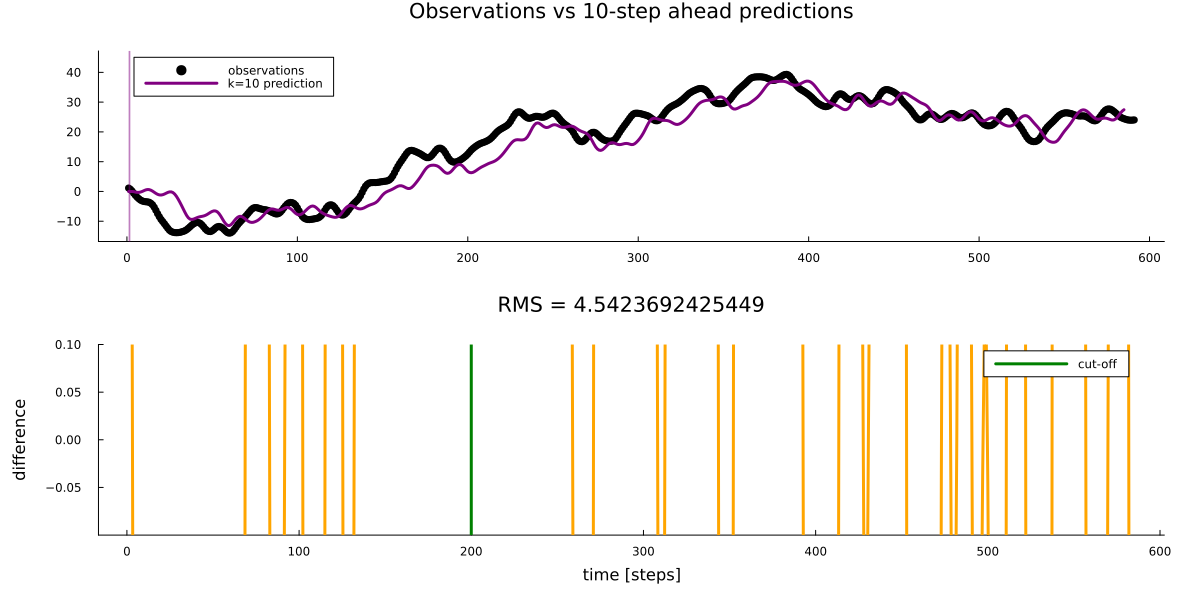

In [70]:
limsb = [minimum(observations)*1.2, maximum(observations)*1.2]
K = 10

residuals = observations[K:K+(N-T)-1] .- [mean(py[k][K]) for k in 1:(N-T)]
cutoff = 200
RMS = sqrt(mean((residuals[cutoff:end]).^2))

p1 = plot(title="Observations vs $K-step ahead predictions", ylims=limsb)
scatter!(observations[K:end], color="black", label="observations")
plot!([mean(py[k][K]) for k in 1:(N-T)], ribbon=[var(py[k][K]) for k in 1:(N-T)], color="purple", label="k=$K prediction")
p2 = plot(xlabel="time [steps]", ylims=[-.1, .1])
plot!(residuals, title="RMS = $RMS", color="orange", ylabel="difference")
vline!([cutoff], color="green", label="cut-off")
plot(p1,p2,layout=grid(2,1), size=(1200,600),)

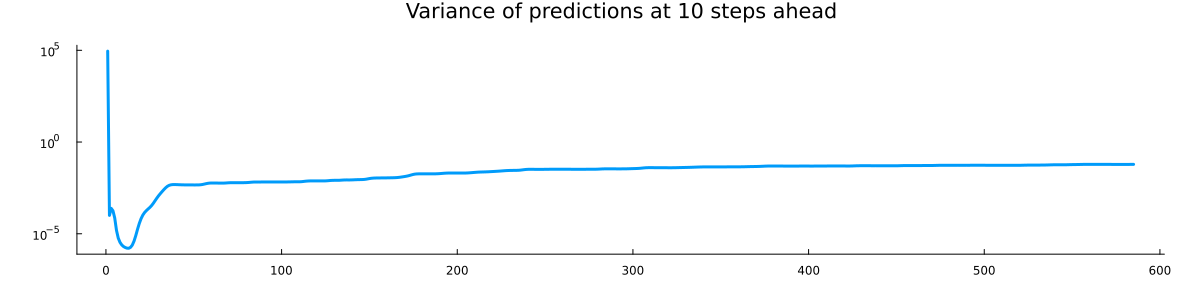

In [71]:
plot([var(py[k][K]) for k in 1:(N-T)], size=(1200,300), title="Variance of predictions at $K steps ahead", yscale=:log10)

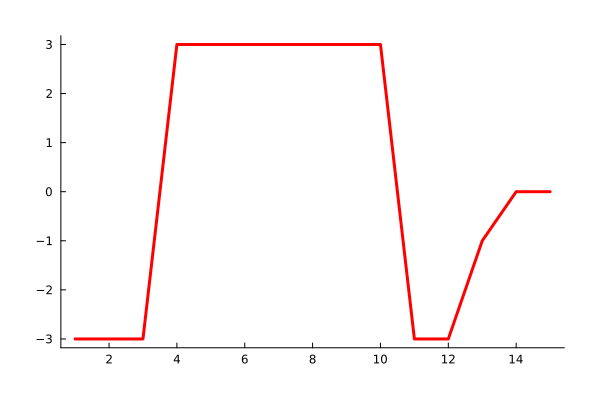

In [72]:
# policy = 3 .*ones(15)
opt_policy = [-3*ones(3); 3*ones(7); -3*ones(2); -1.; zeros(2)]
plot(opt_policy, color="red")

In [73]:
pendulum.state = [0.0, 0.]
sys_trajectory = sim_trajectory(pendulum, opt_policy)

2×15 Matrix{Float64}:
  0.0  -0.12   -0.3552   -0.677504  …  3.06927   3.11313   3.14105
 -0.6  -1.176  -1.61152  -0.605891     0.219295  0.139635  0.106129

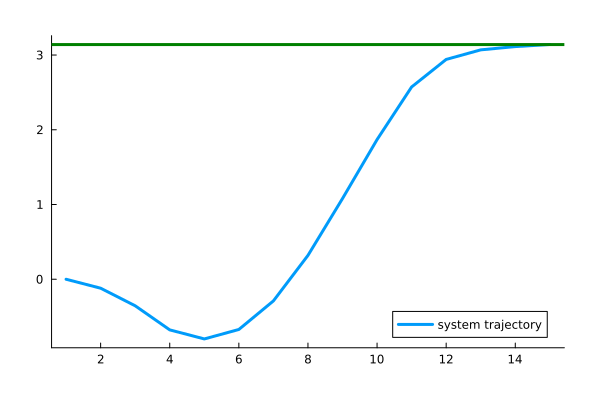

In [74]:
plot(sys_trajectory[1,:], label="system trajectory")
hline!([mean(goal)*normalize_output], color="green")

## Experiments

In [75]:
# Length of trial
N = 50
tsteps = range(0.0, step=Δt, length=N)
T = 12

# Set control properties
goal = NormalMeanVariance(3.14 ./ normalize_output, 1e-3)
control_prior = 0.0
num_iters = 4
u_lims = (-3., 3.)
tlimit = 10

# Specify prior distributions
pτ0 = GammaShapeRate(1e3, 1e0)
pθ0 = MvNormalMeanCovariance(randn(M)./100, 10diagm(ones(M)))

init_state = [0.0, 0.0];

### Expected Free Energy minimization

In [77]:
# Start system
pendulum = SPendulum(init_state = [0.0, 0.0], 
                     torque_lims = u_lims,
                     mass = sys_mass, 
                     length = sys_length, 
                     damping = sys_damping, 
                     mnoise_sd = sys_mnoise_sd, 
                     Δt=Δt,
                     norm_output=normalize_output)

# Track beliefs
py_EFE = []
pτ_EFE = [pτ0]
pθ_EFE = [pθ0]
goals = Any[false for t in 1:T]

# Start agent
agent = NARXAgent(qθ[end], qτ[end], 
                  goal_prior=goals, 
                  delay_in=Lu, 
                  delay_out=Ly,
                  basisfn_class="rbf", 
                  basisfn_params=(centers,scales),
                  thorizon=T,
                  num_iters=num_iters)

# Preallocate
y_EFE = zeros(N)
u_EFE = zeros(N+T)
FE_EFE = zeros(num_iters, N)
policy = zeros(T)

@showprogress for k in 1:N
    
    # Act upon environment
    step!(pendulum, u_EFE[k])
    y_EFE[k] = pendulum.sensor

    """Perception"""
    
    # Update parameter beliefs
    NARXAgents.update!(agent, y_EFE[k], u_EFE[k])
    FE_EFE[:,k] = agent.free_energy
    push!(pθ_EFE, agent.qθ)
    push!(pτ_EFE, agent.qτ)

    """Action"""

    # Move goal closer
    update_goals!(goals, goal)
    agent.goals = goals

    # Optimal control
    policy = minimizeEFE(agent, goals, time_limit=tlimit, control_lims=u_lims)
    # policy = minimizeEFE(agent, goals, u_0=policy, time_limit=tlimit, control_lims=u_lims)
    u_EFE[k+1:k+T] = policy

    # Store future predictions
    push!(py_EFE, predictions(agent, policy, time_horizon=T))
end

Progress:   4%|█▋                                       |  ETA: 0:03:00

Progress:   6%|██▌                                      |  ETA: 0:02:06

Progress:   8%|███▎                                     |  ETA: 0:01:39

Progress:  10%|████▏                                    |  ETA: 0:01:22

Progress:  12%|████▉                                    |  ETA: 0:01:11

Progress:  14%|█████▊                                   |  ETA: 0:01:03

Progress:  16%|██████▌                                  |  ETA: 0:00:57

Progress:  18%|███████▍                                 |  ETA: 0:00:52

Progress:  20%|████████▎                                |  ETA: 0:00:49

Progress:  22%|█████████                                |  ETA: 0:00:45

Progress:  24%|█████████▉                               |  ETA: 0:00:43

Progress:  26%|██████████▋                              |  ETA: 0:00:40

Progress:  28%|███████████▌                             |  ETA: 0:00:38

Progress:  30%|████████████▎                            |  ETA: 0:00:36

Progress:  32%|█████████████▏                           |  ETA: 0:00:34

Progress:  34%|██████████████                           |  ETA: 0:00:33

Progress:  36%|██████████████▊                          |  ETA: 0:00:32

Progress:  38%|███████████████▋                         |  ETA: 0:00:30

Progress:  40%|████████████████▍                        |  ETA: 0:00:29

Progress:  42%|█████████████████▎                       |  ETA: 0:00:28

Progress:  44%|██████████████████                       |  ETA: 0:00:26

Progress:  46%|██████████████████▉                      |  ETA: 0:00:25

Progress:  48%|███████████████████▋                     |  ETA: 0:00:24

Progress:  50%|████████████████████▌                    |  ETA: 0:00:23

Progress:  52%|█████████████████████▍                   |  ETA: 0:00:22

Progress:  54%|██████████████████████▏                  |  ETA: 0:00:21

Progress:  56%|███████████████████████                  |  ETA: 0:00:20

Progress:  58%|███████████████████████▊                 |  ETA: 0:00:19

Progress:  60%|████████████████████████▋                |  ETA: 0:00:18

Progress:  62%|█████████████████████████▍               |  ETA: 0:00:17

Progress:  64%|██████████████████████████▎              |  ETA: 0:00:16

Progress:  66%|███████████████████████████              |  ETA: 0:00:15

Progress:  68%|███████████████████████████▉             |  ETA: 0:00:14

Progress:  70%|████████████████████████████▊            |  ETA: 0:00:13

Progress:  72%|█████████████████████████████▌           |  ETA: 0:00:12

Progress:  74%|██████████████████████████████▍          |  ETA: 0:00:11

Progress:  76%|███████████████████████████████▏         |  ETA: 0:00:10

Progress:  78%|████████████████████████████████         |  ETA: 0:00:09

Progress:  80%|████████████████████████████████▊        |  ETA: 0:00:08

Progress:  82%|█████████████████████████████████▋       |  ETA: 0:00:08

Progress:  84%|██████████████████████████████████▌      |  ETA: 0:00:07

Progress:  86%|███████████████████████████████████▎     |  ETA: 0:00:06

Progress:  88%|████████████████████████████████████▏    |  ETA: 0:00:05

Progress:  90%|████████████████████████████████████▉    |  ETA: 0:00:04

Progress:  92%|█████████████████████████████████████▊   |  ETA: 0:00:03

Progress:  94%|██████████████████████████████████████▌  |  ETA: 0:00:02

Progress:  96%|███████████████████████████████████████▍ |  ETA: 0:00:02

Progress:  98%|████████████████████████████████████████▏|  ETA: 0:00:01

Progress: 100%|█████████████████████████████████████████| Time: 0:00:41


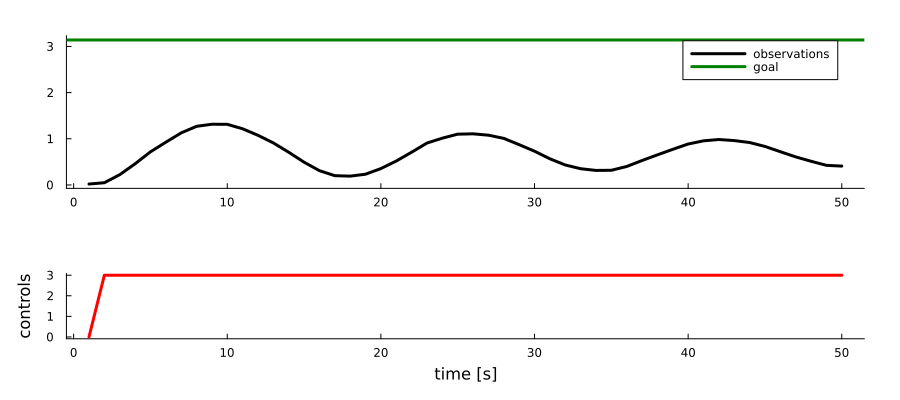

In [78]:
p1 = plot(y_EFE, color="black", label="observations")
hline!([mean(goal)], color="green", label="goal")
p4 = plot(u_EFE[1:end-T], color="red", ylabel="controls", xlabel="time [s]")

plot(p1,p4, layout=grid(2,1, heights=[.7, .3]), size=(900,400))

In [79]:
savefig("figures/NARX-EFE-1Pendulum-trial.png")

"/home/wmkouw/syndr/Wouter/Onderzoek/Projecten/tue/efe-acquisition/narx-efe/pendulum/figures/NARX-EFE-1Pendulum-trial.png"

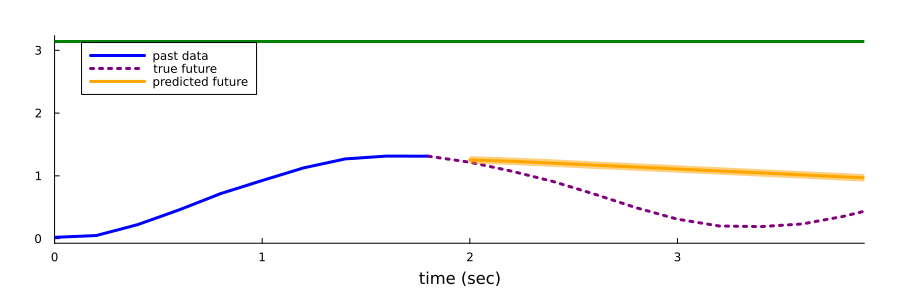

In [80]:
window = 5
k = 10
plot(tsteps[1:k], y_EFE[1:k], color="blue", xlims=(tsteps[1], tsteps[window+T+1]+0.5), label="past data", xlabel="time (sec)", size=(900,300))
plot!(tsteps[k:k+T], y_EFE[k:k+T], color="purple", label="true future", linestyle=:dot)
plot!(tsteps[k+1:k+T], mean.(py_EFE[k]), ribbon=var.(py_EFE[k]), label="predicted future", color="orange", legend=:topleft)

hline!([mean(goal)], color="green")

┌ Info: Saved animation to /home/wmkouw/syndr/Wouter/Onderzoek/Projecten/tue/efe-acquisition/narx-efe/pendulum/figures/NARX-EFE-1Pendulum-planning.gif
└ @ Plots /home/wmkouw/.julia/packages/Plots/3BCH5/src/animation.jl:156


Plots.AnimatedGif("/home/wmkouw/syndr/Wouter/Onderzoek/Projecten/tue/efe-acquisition/narx-efe/pendulum/figures/NARX-EFE-1Pendulum-planning.gif")
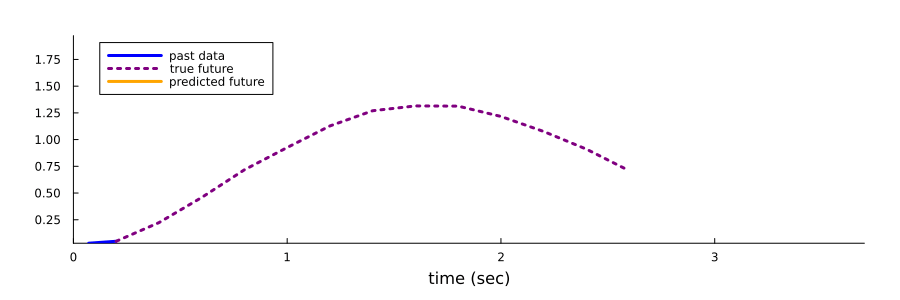

In [81]:
limsb = [minimum(y_EFE)*1.5, maximum(y_EFE)*1.5]

window = 4

anim = @animate for k in 2:2:(N-T-1)
    
    if k <= window
        plot(tsteps[1:k], y_EFE[1:k], color="blue", xlims=(tsteps[1], tsteps[window+T+1]+0.5), label="past data", xlabel="time (sec)", ylims=limsb, size=(900,300))
        plot!(tsteps[k:k+T], y_EFE[k:k+T], color="purple", label="true future", linestyle=:dot)
        plot!(tsteps[k+1:k+T], mean.(py_EFE[k]), ribbon=var.(py_EFE[k]), label="predicted future", color="orange", legend=:topleft)
        hline!([mean(goal)], color="green")
    else
        plot(tsteps[k-window:k], y_EFE[k-window:k], color="blue", xlims=(tsteps[k-window], tsteps[k+T+1]+0.5), label="past data", xlabel="time (sec)", ylims=limsb, size=(900,300))
        plot!(tsteps[k:k+T], y_EFE[k:k+T], color="purple", label="true future", linestyle=:dot)
        plot!(tsteps[k+1:k+T], mean.(py_EFE[k]), ribbon=var.(py_EFE[k]), label="prediction", color="orange", legend=:topleft)
        hline!([mean(goal)], color="green")
    end
    
end
gif(anim, "figures/NARX-EFE-1Pendulum-planning.gif", fps=3)

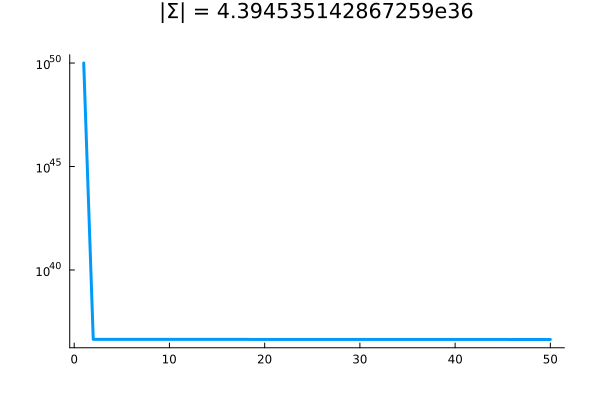

In [82]:
dSθ_EFE = [det(cov(pθ_EFE[k])) for k in 1:N]
final_dSθ_EFE = dSθ_EFE[end]
plot(dSθ_EFE, title="|Σ| = $final_dSθ_EFE", yscale=:log10)

### Mean Squared Error minimization

In [84]:
# Start system
pendulum = SPendulum(init_state = init_state, 
                     torque_lims = u_lims,
                     mass = sys_mass, 
                     length = sys_length, 
                     damping = sys_damping, 
                     mnoise_sd = sys_mnoise_sd, 
                     Δt=Δt,
                     norm_output=normalize_output)

# Track beliefs
py_MSE = [] 
pτ_MSE = [pτ0]
pθ_MSE = [pθ0]
goals = Any[false for t in 1:T]

# Start agent
agent = NARXAgent(qθ[end], qτ[end], 
                  goal_prior=goals, 
                  delay_in=Lu, 
                  delay_out=Ly, 
                  basisfn_class="rbf",
                  basisfn_params=(centers,scales),
                  thorizon=T,
                  control_prior=control_prior,
                  num_iters=num_iters)

# Preallocate
y_MSE = zeros(N)
u_MSE = zeros(N+T)
FE_MSE = zeros(num_iters, N)
policy = zeros(T)

@showprogress for k in 1:N
    
    # Act upon environment
    step!(pendulum, u_MSE[k])
    y_MSE[k] = pendulum.sensor

    """Perception"""
    
    # Update parameter beliefs
    NARXAgents.update!(agent, y_MSE[k], u_MSE[k])
    FE_MSE[:,k] = agent.free_energy
    push!(pθ_MSE, agent.qθ)
    push!(pτ_MSE, agent.qτ)

    """Action"""

    # Move goal closer
    update_goals!(goals, goal)
    agent.goals = goals
    
    # Optimal control
    policy = minimizeMSE(agent, goals, time_limit=tlimit, control_lims=u_lims)
    u_MSE[k+1:k+T] = policy
    
    # Store future predictions
    push!(py_MSE, predictions(agent, policy, time_horizon=T))
    
end

Progress:   4%|█▋                                       |  ETA: 0:00:59

Progress:   6%|██▌                                      |  ETA: 0:00:43

Progress:   8%|███▎                                     |  ETA: 0:00:36

Progress:  10%|████▏                                    |  ETA: 0:00:31

Progress:  12%|████▉                                    |  ETA: 0:00:27

Progress:  14%|█████▊                                   |  ETA: 0:00:24

Progress:  16%|██████▌                                  |  ETA: 0:00:23

Progress:  18%|███████▍                                 |  ETA: 0:00:21

Progress:  20%|████████▎                                |  ETA: 0:00:20

Progress:  22%|█████████                                |  ETA: 0:00:19

Progress:  24%|█████████▉                               |  ETA: 0:00:18

Progress:  26%|██████████▋                              |  ETA: 0:00:17

Progress:  28%|███████████▌                             |  ETA: 0:00:16

Progress:  30%|████████████▎                            |  ETA: 0:00:15

Progress:  32%|█████████████▏                           |  ETA: 0:00:14

Progress:  34%|██████████████                           |  ETA: 0:00:13

Progress:  36%|██████████████▊                          |  ETA: 0:00:13

Progress:  38%|███████████████▋                         |  ETA: 0:00:12

Progress:  40%|████████████████▍                        |  ETA: 0:00:12

Progress:  42%|█████████████████▎                       |  ETA: 0:00:11

Progress:  44%|██████████████████                       |  ETA: 0:00:10

Progress:  46%|██████████████████▉                      |  ETA: 0:00:10

Progress:  48%|███████████████████▋                     |  ETA: 0:00:10

Progress:  50%|████████████████████▌                    |  ETA: 0:00:09

Progress:  52%|█████████████████████▍                   |  ETA: 0:00:09

Progress:  54%|██████████████████████▏                  |  ETA: 0:00:08

Progress:  56%|███████████████████████                  |  ETA: 0:00:08

Progress:  58%|███████████████████████▊                 |  ETA: 0:00:07

Progress:  60%|████████████████████████▋                |  ETA: 0:00:07

Progress:  62%|█████████████████████████▍               |  ETA: 0:00:07

Progress:  64%|██████████████████████████▎              |  ETA: 0:00:06

Progress:  66%|███████████████████████████              |  ETA: 0:00:06

Progress:  68%|███████████████████████████▉             |  ETA: 0:00:06

Progress:  70%|████████████████████████████▊            |  ETA: 0:00:05

Progress:  72%|█████████████████████████████▌           |  ETA: 0:00:05

Progress:  74%|██████████████████████████████▍          |  ETA: 0:00:04

Progress:  76%|███████████████████████████████▏         |  ETA: 0:00:04

Progress:  78%|████████████████████████████████         |  ETA: 0:00:04

Progress:  80%|████████████████████████████████▊        |  ETA: 0:00:03

Progress:  82%|█████████████████████████████████▋       |  ETA: 0:00:03

Progress:  84%|██████████████████████████████████▌      |  ETA: 0:00:03

Progress:  86%|███████████████████████████████████▎     |  ETA: 0:00:02

Progress:  88%|████████████████████████████████████▏    |  ETA: 0:00:02

Progress:  90%|████████████████████████████████████▉    |  ETA: 0:00:02

Progress:  92%|█████████████████████████████████████▊   |  ETA: 0:00:01

Progress:  94%|██████████████████████████████████████▌  |  ETA: 0:00:01

Progress:  96%|███████████████████████████████████████▍ |  ETA: 0:00:01

Progress:  98%|████████████████████████████████████████▏|  ETA: 0:00:00

Progress: 100%|█████████████████████████████████████████| Time: 0:00:16


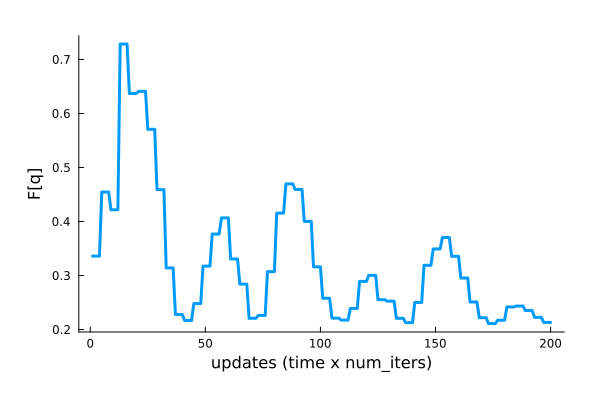

In [85]:
plot(FE_MSE[:], xlabel="updates (time x num_iters)", ylabel="F[q]")

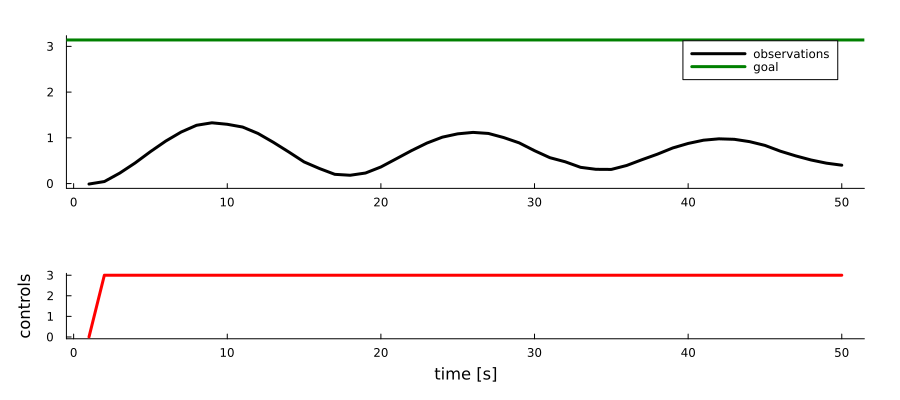

In [86]:
p1 = plot(y_MSE, color="black", label="observations")
hline!([mean(goal)], color="green", label="goal")
p4 = plot(u_MSE[1:end-T], color="red", ylabel="controls", xlabel="time [s]")

plot(p1,p4, layout=grid(2,1, heights=[.7, .3]), size=(900,400))

In [87]:
savefig("figures/NARX-MSE-1Pendulum-trial.png")

"/home/wmkouw/syndr/Wouter/Onderzoek/Projecten/tue/efe-acquisition/narx-efe/pendulum/figures/NARX-MSE-1Pendulum-trial.png"

┌ Info: Saved animation to /home/wmkouw/syndr/Wouter/Onderzoek/Projecten/tue/efe-acquisition/narx-efe/pendulum/figures/NARX-MSE-1Pendulum-planning.gif
└ @ Plots /home/wmkouw/.julia/packages/Plots/3BCH5/src/animation.jl:156


Plots.AnimatedGif("/home/wmkouw/syndr/Wouter/Onderzoek/Projecten/tue/efe-acquisition/narx-efe/pendulum/figures/NARX-MSE-1Pendulum-planning.gif")
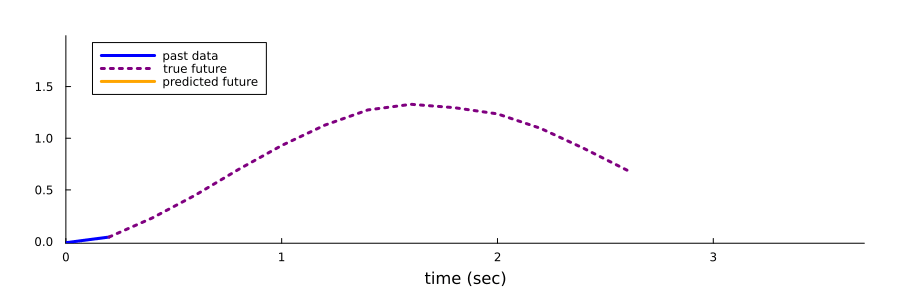

In [88]:
limsb = [minimum(y_MSE)*1.5, maximum(y_MSE)*1.5]

window = 4

anim = @animate for k in 2:2:(N-T-1)
    
    if k <= window
        plot(tsteps[1:k], y_MSE[1:k], color="blue", xlims=(tsteps[1], tsteps[window+T+1]+0.5), label="past data", xlabel="time (sec)", ylims=limsb, size=(900,300))
        plot!(tsteps[k:k+T], y_MSE[k:k+T], color="purple", label="true future", linestyle=:dot)
        plot!(tsteps[k+1:k+T], mean.(py_MSE[k]), ribbon=var.(py_MSE[k]), label="predicted future", color="orange", legend=:topleft)
        hline!([mean(goal)], color="green")
    else
        plot(tsteps[k-window:k], y_MSE[k-window:k], color="blue", xlims=(tsteps[k-window], tsteps[k+T+1]+0.5), label="past data", xlabel="time (sec)", ylims=limsb, size=(900,300))
        plot!(tsteps[k:k+T], y_MSE[k:k+T], color="purple", label="true future", linestyle=:dot)
        plot!(tsteps[k+1:k+T], mean.(py_MSE[k]), ribbon=var.(py_MSE[k]), label="prediction", color="orange", legend=:topleft)
        hline!([mean(goal)], color="green")
    end
    
end
gif(anim, "figures/NARX-MSE-1Pendulum-planning.gif", fps=10)

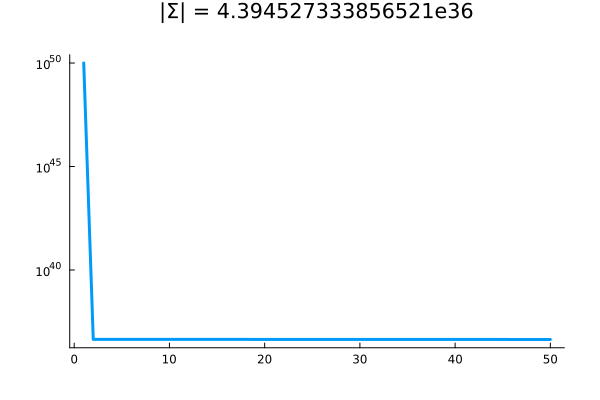

In [89]:
dSθ_MSE = [det(cov(pθ_MSE[k])) for k in 1:N]
final_dSθ_MSE = dSθ_MSE[end]
plot(dSθ_MSE, title="|Σ| = $final_dSθ_MSE", yscale=:log10)

### Comparisons

In [90]:
println("Final |Σ| MSE = $final_dSθ_MSE")
println("Final |Σ| EFE = $final_dSθ_EFE")

Final |Σ| MSE = 4.394527333856521e36
Final |Σ| EFE = 4.394535142867259e36


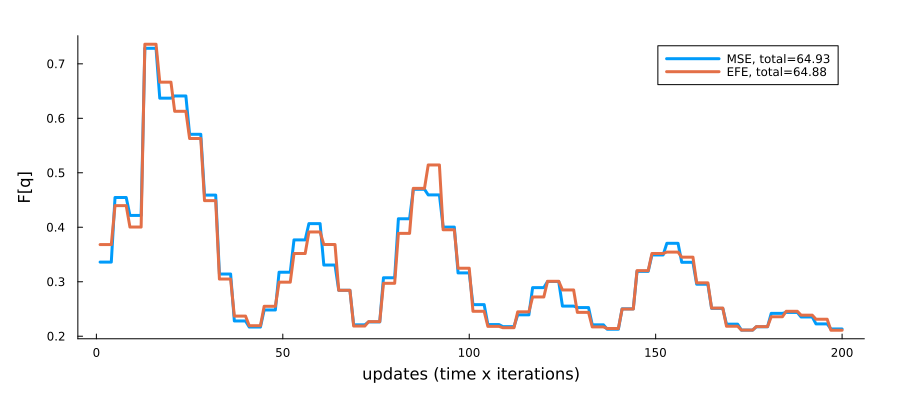

In [91]:
sF_MSE = round(sum(FE_MSE[:]), digits=2)
sF_EFE = round(sum(FE_EFE[:]), digits=2)

plot(xlabel="updates (time x iterations)", ylabel="F[q]", size=(900,400))
plot!(FE_MSE[:], label="MSE, total=$sF_MSE")
plot!(FE_EFE[:], label="EFE, total=$sF_EFE")

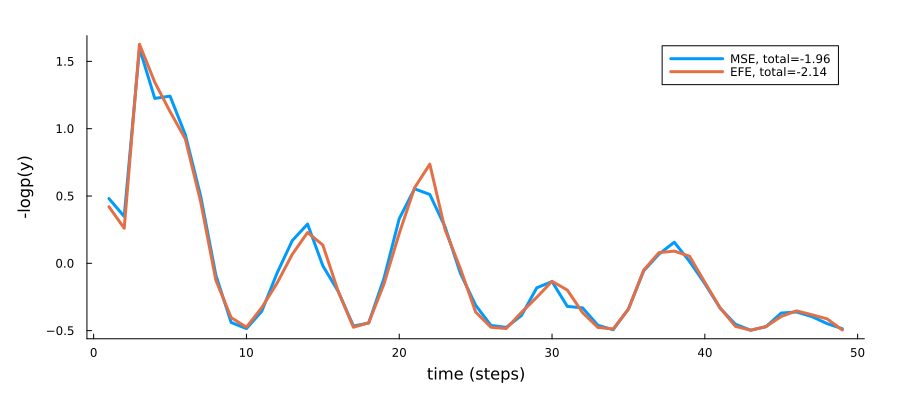

In [92]:
evidence_MSE = [-logpdf(py_MSE[k][1], y_MSE[k+1]) for k in 1:(N-1)]
evidence_EFE = [-logpdf(py_EFE[k][1], y_EFE[k+1]) for k in 1:(N-1)]

total_evidence_MSE = round(sum(evidence_MSE), digits=2)
total_evidence_EFE = round(sum(evidence_EFE), digits=2)

plot(xlabel="time (steps)", ylabel="-logp(y)", size=(900,400))
plot!(evidence_MSE, label="MSE, total=$total_evidence_MSE")
plot!(evidence_EFE, label="EFE, total=$total_evidence_EFE")

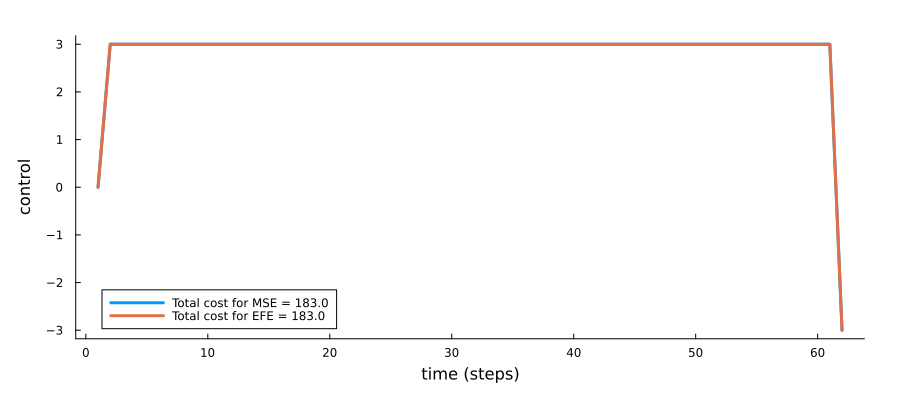

In [93]:
CC_MSE = round(sum(abs.(u_MSE)), digits=2)
CC_EFE = round(sum(abs.(u_EFE)), digits=2)

plot(xlabel="time (steps)", ylabel="control", size=(900,400))
plot!(u_MSE, label="Total cost for MSE = $CC_MSE")
plot!(u_EFE, label="Total cost for EFE = $CC_EFE")

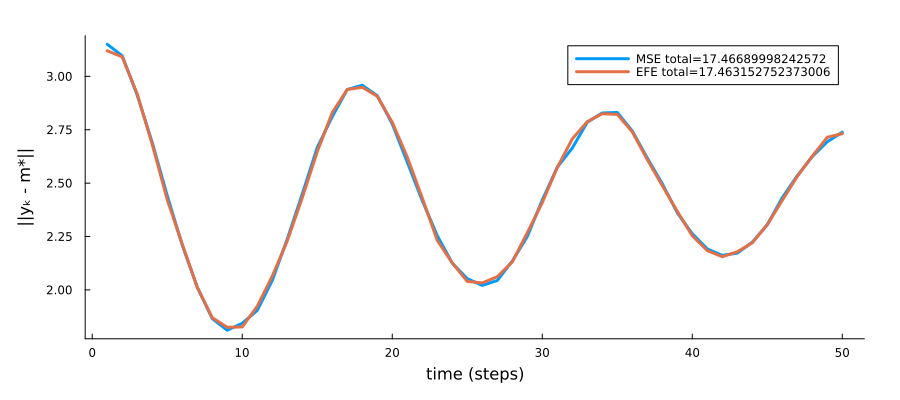

In [94]:
J_MSE = [norm(y_MSE[k] - mean(goal),2) for k in 1:N]
J_EFE = [norm(y_EFE[k] - mean(goal),2) for k in 1:N]

sJ_MSE = norm(y_MSE .- mean(goal),2)
sJ_EFE = norm(y_EFE .- mean(goal),2)

plot(xlabel="time (steps)", ylabel="||yₖ - m*||", size=(900,400))
plot!(J_MSE, label="MSE total=$sJ_MSE")
plot!(J_EFE, label="EFE total=$sJ_EFE")